# Exploratory Data Analysis

This notebook performs the initial Exploratory Data Analysis on the Food101 dataset. A thorough understanding of the data is the foundation for building an effective model.

Our investigation will proceed in three key steps:

1/ Visual Inspection of Raw Images:

>We will load and display a few random raw images to get a qualitative feel for the data. This helps us understand their general properties like aspect ratio, quality, and typical content.

2/ Preprocessing Pipeline Verification:

>We will define our image transformation pipeline using `torchvision.transforms` (e.g., resizing and converting to tensors). We will then visualize a sample image 'before' and 'after' the transformation to confirm the pipeline works as expected.

3/ Class Distribution Analysis:

>We will analyze the distribution of images across all 101 classes. This is critical to identify any potential **class imbalance**, which directly influences our training strategy and choice of evaluation metrics.

## 01. Import base libraries

In [15]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from PIL import Image
from pathlib import Path

from src.helper_functions import plot_transformed_images

## 02. Raw data exploration

Let's write some code to:

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since I am working with images, I will open the random image path using `PIL.Image.open()`.
5. Show the image and print some metadata.

Random image path: C:\Users\ToanTo\Desktop\food101-classifier\food101-classifier\data\raw\food-101\images\dumplings\1276808.jpg
Image class: dumplings
Image height: 512
Image width: 512


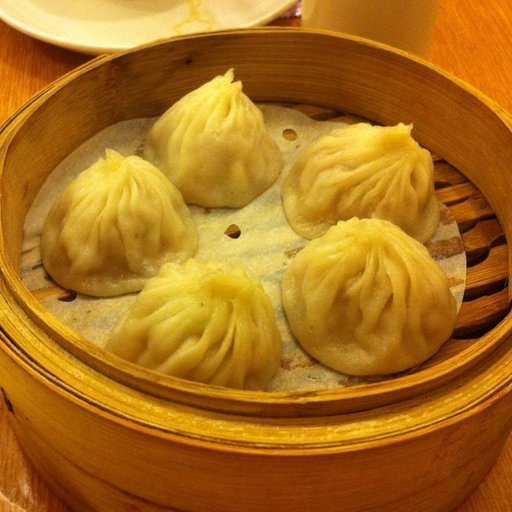

In [16]:
# Set up path to data folder
data_path = Path("C:/Users/ToanTo/Desktop/food101-classifier/food101-classifier/data/")
image_path = data_path / "raw/food-101/images/"

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

**Observation:** The images vary significantly in size and aspect ratio. The majority are color images (RGB), and the overall quality appears to be good. A resizing and normalization step is mandatory for model training.

## 03. Preprocessing pipeline test

Before we can use our image data with PyTorch we need to:
1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.


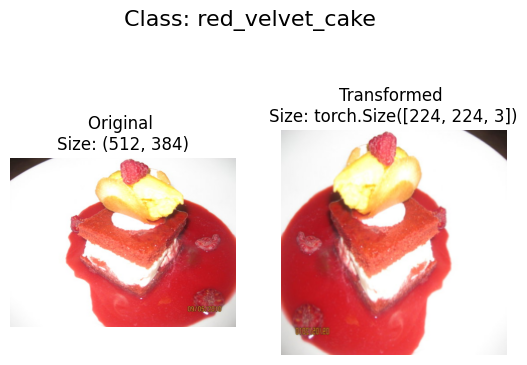

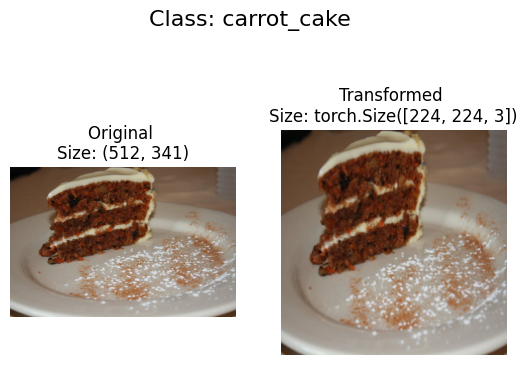

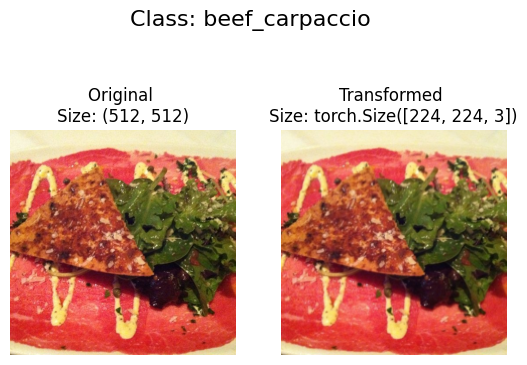

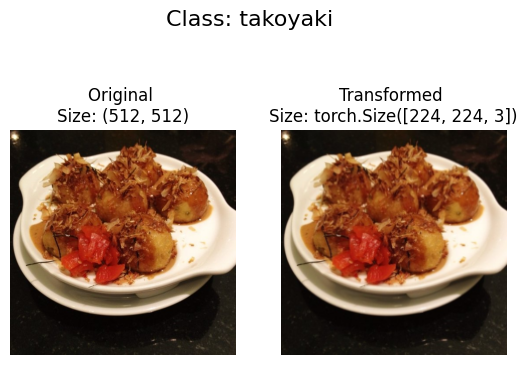

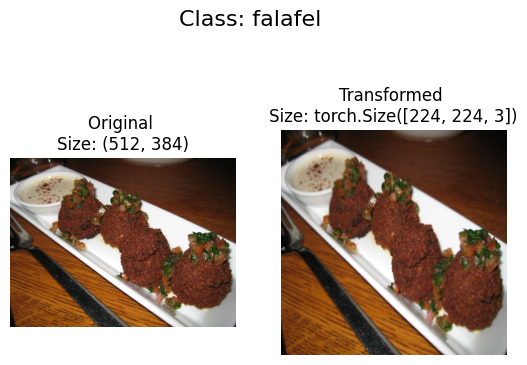

In [18]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 224x224
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=5)

**Observation:** The preprocessing pipeline works as expected. Images are successfully resized to 224x224 and converted into Tensors with the shape [H, W, C]. This pipeline is ready to be used in our custom Dataset and DataLoader.

## 04. Data distribution analysis

A critical step in any classification project is to understand the distribution of data across different classes. This analysis is crucial because a significant class imbalance can lead to a biased model that performs well on majority classes but poorly on minority ones. The findings will directly influence our choice of evaluation metrics and determine if techniques like oversampling or class weighting are necessary for training.

In [19]:
### Step 1: Define Paths and Load Metadata
# Define the root directory for the dataset
data_path = Path("C:/Users/ToanTo/Desktop/food101-classifier/food101-classifier/data/raw/food-101/")

# Paths to the files that define the train and test sets
train_file_path = data_path / "meta" / "train.txt"
test_file_path = data_path / "meta" / "test.txt"

# Check if the training file exists to avoid errors
assert train_file_path.exists(), f"File not found: {train_file_path}"

### Step 2: Read and Process the train.txt File

# The `train.txt` file contains a list of relative image paths, e.g., "apple_pie/1005649.jpg".
# The parent directory name ("apple_pie") serves as the class label.
# I will read this file and count the occurrences of each class name.

# Read all lines from the train.txt file
with open(train_file_path, 'r') as f:
    # Each line is a relative image path
    train_image_paths = f.read().strip().splitlines()

# Extract the class name from each path (the part before the first '/')
train_class_names = [path.split('/')[0] for path in train_image_paths]

# Use Pandas to efficiently count the number of images per class
train_counts = pd.Series(train_class_names).value_counts()

# Print the top 5 most frequent and least frequent classes to get a quick overview
print("Top 5 most frequent classes in the training set:")
print(train_counts.head())
print("\nBottom 5 least frequent classes in the training set:")
print(train_counts.tail())

Top 5 most frequent classes in the training set:
apple_pie         750
baby_back_ribs    750
baklava           750
beef_carpaccio    750
beef_tartare      750
Name: count, dtype: int64

Bottom 5 least frequent classes in the training set:
tacos           750
takoyaki        750
tiramisu        750
tuna_tartare    750
waffles         750
Name: count, dtype: int64


**Observation: the dataset is perfectly balanced**

The output above confirms that the training set is perfectly balanced. As we can see, both the top 5 most frequent classes and the bottom 5 least frequent classes contain exactly 750 images. This implies that every single class in the training data has the same number of samples.

This is an ideal scenario for a classification task, as it prevents the model from becoming biased towards majority classes and allows us to use accuracy as a reliable primary metric for evaluation.

To better illustrate this uniform distribution, let's visualize the counts for a subset of the classes.

C:\Users\ToanTo\AppData\Local\Temp\ipykernel_12592\251010774.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


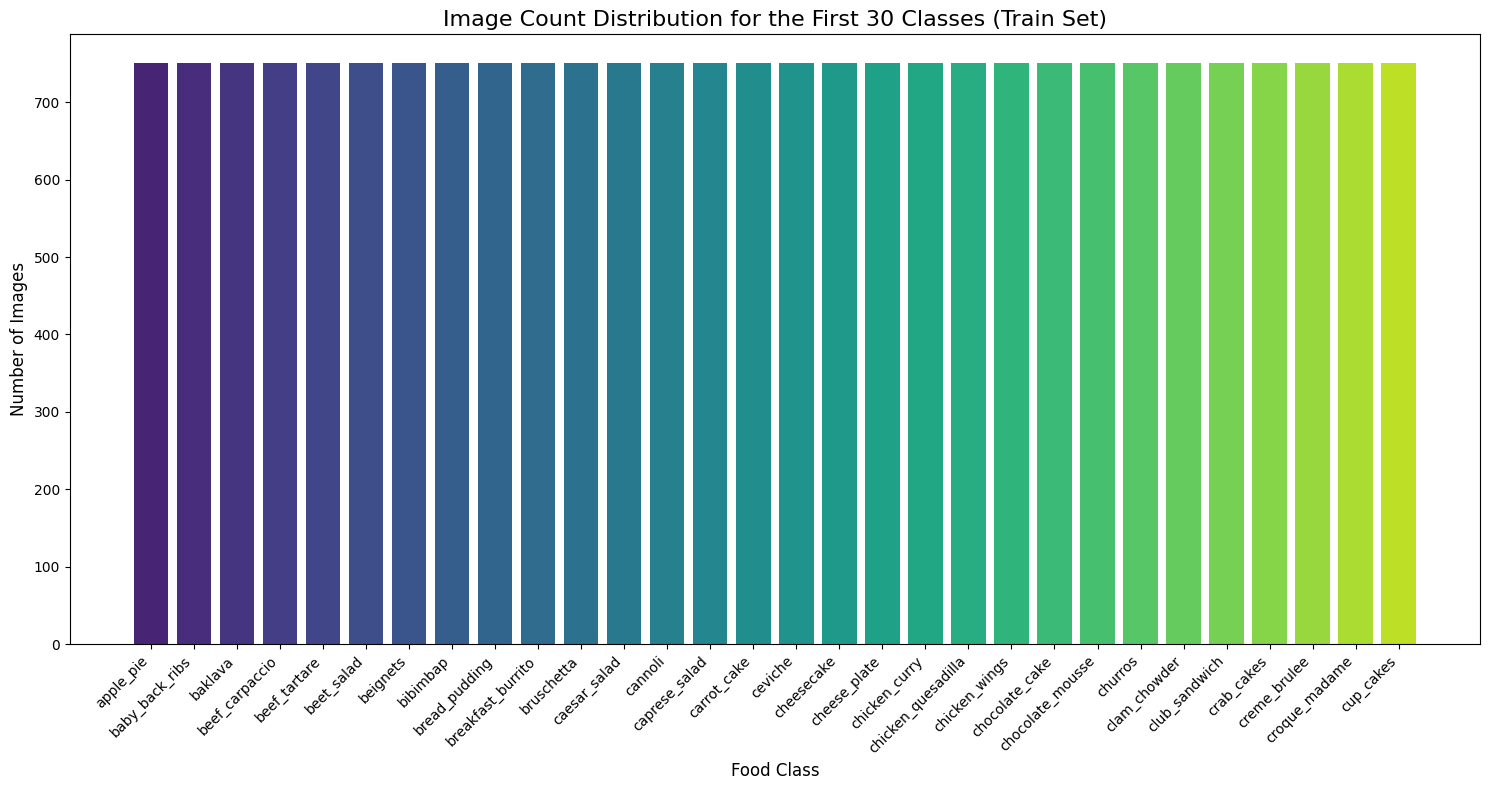

In [20]:
### Step 3: Visualize the Class Distribution

# To keep the plot clean, we'll visualize the distribution for the first 30 classes.
subset_counts = train_counts.head(30)

## 1. Create a Color Palette
# Get the 'viridis' colormap from matplotlib to create a pleasant color gradient
cmap = plt.cm.get_cmap('viridis')
# Generate a list of distinct colors based on the number of bars we have
# `np.linspace(...)` creates evenly spaced numbers to sample the colormap
colors = cmap(np.linspace(0.1, 0.9, len(subset_counts)))

## 2. Plot the Bar Chart with Custom Colors
# Create a larger figure for better readability
plt.figure(figsize=(15, 8))

# Use plt.bar() and pass the generated color list to the `color` parameter
plt.bar(x=subset_counts.index, height=subset_counts.values, color=colors)

## 3. Customize the Plot
# Set the title and labels with appropriate font sizes
plt.title("Image Count Distribution for the First 30 Classes (Train Set)", fontsize=16)
plt.xlabel("Food Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Rotate x-axis labels to prevent them from overlapping
plt.xticks(rotation=45, ha="right")

# Adjust plot to ensure everything fits without being clipped
plt.tight_layout()

## 4. Display the Plot
plt.show()

## 05. EDA summary & key takeaways

- **Diverse Image Dimensions:** The raw images exhibit significant variation in size and aspect ratio. This confirms that a mandatory standardization step, such as resizing, is required in our preprocessing pipeline.

- **Pipeline Verification:** The preprocessing pipeline, which utilizes `transforms.Resize` and `transforms.ToTensor`, has been successfully verified. It correctly transforms images into consistently shaped tensors ([H, W, C]), making them suitable for model input.

- **Perfectly Balanced Dataset:** A crucial finding is that the entire dataset (both training and testing sets) is perfectly balanced. This is an ideal condition for a classification task, allowing us to confidently use **Accuracy** as the primary metric for evaluating model performance.

- **Next Steps:** Based on these findings, the exploratory phase is complete. We will now proceed to build the `DataLoaders` and begin the model training and comparison process as outlined in Phase 1 of the project.